# 상대적 카테고리 중요도 - RCI(Relative Category Importance) #

ABC 분석(ABC Analysis)을 기반으로 카테고리별 매출 기여도를 수치화하여 상대적으로 중요한 카테고리를 선정하는 커스텀 KPI

## -ABC 분석(파레토 분석)이란?


쇼핑몰, 백화점 등등 카테고리별 매출 기여도를 구하는 마케팅 전략

파레토의 법칙
- 전체 결과의 80%가 전체 원인의 20%에서 일어나는 현상

현재 비지니스 적용
- 상위 20%의 카테고리가 매출의 80%를 차지함

![graph.png](graph.png)

## -RCI 계산 방법

전체 ABC 분석  
* 기준 A,B 그룹 카테고리 선정 C그룹 제외(영향 적음)

분기별 ABC 분석  
* 분기별 기준 A,B 그룹에서 달라지는 품목 확인 > 분기별 변동성 품목 확인 
* 기준 A,B 그룹내에 변동성 품목 분기별 매출 그래프로 패턴 찾기  
* 분기별 추천 및 집중 카테고리 선정  

월별 카테고리 매출 비율  
* 최근 3개월 기준 A,B 그룹 매출 비율 증감률 확인 > 최신 동향 반영
* 전체 기간 매출 비율 증감률 확인 > 성장율 확인

<font color=red> 최종 품목 선정 </font>  
상대적 카테고리 중요도(RCI) = 전체 기간 매출 비율 증감률 정규화 값*(0.4) + 최근 1개월간 매출 비율 증감률 정규화 값*(0.4) + 한달 전 1개월간 매출 비율 증감률 정규화 값*(0.2)

**RCI 0.5 이상 + 예외(분기별 추천)**

# ==================================================== #

# [사전 작업] #

## -설정
 
그룹 기준치 설정  
* 일반적인 쇼핑몰 매출 기여도 분석과 같이 누적 매출 70% ,90%, 100%로 나누어 A,B,C 그룹 설정
  
매출액 계산법  
http://www.eanse.com/myqna/view/7083  

택배사와 계약 x 
* 매출액 = 판매가 + 화물비용  

택배사와 계약 o  
* 매출액 = 판매가 

해당 분석은 택배사와 계약했다고 설정

## -데이터 준비

In [1]:
# 라이브러리 불러오기

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
from sklearn.preprocessing import MinMaxScaler

# 한글 폰트 설정
font_path = "C:/Windows/Fonts/malgun.ttf"  
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)

In [2]:
# 데이터 불러오기

order_items= pd.read_csv('data/order_items.csv')
orders= pd.read_csv('data/orders.csv')
products=pd.read_csv('data/products.csv') 

In [3]:
# 데이터 합치기

cat = pd.merge(order_items, products , on = 'Product_id' , how='inner')
cat = pd.merge(cat, orders, on = 'Order_id' , how='inner')

cat['Order_purchase_timestamp'] = pd.to_datetime(cat['Order_purchase_timestamp'])

# 시간 순서대로 정렬
cat = cat.sort_values(by='Order_purchase_timestamp')

# 년 , 월 컬럼 추가
cat['year'] = cat['Order_purchase_timestamp'].dt.year
cat['month'] = cat['Order_purchase_timestamp'].dt.month

# 초기 불균형 데이터 2017년 제외 데이터
# cat = cat[cat['year'] != 2017]

# 확인
cat.head(1)

,Order_id,Order_item_id,Product_id,Seller_id,Price,Freight_value,Product_category_name,Product_weight_g,Product_length_cm,Product_height_cm,Product_width_cm,Customer_id,Order_status,Order_purchase_timestamp,Order_delivered_carrier_date,Order_delivered_customer_date,Order_estimated_delivery_date,year,month
71738,ORDER_82627,1,PRODUCT_13424,SELLER_1784,29.9,15.56,watches_gifts,300.0,16.0,16.0,16.0,CUSTOMER_34191,delivered,2017-10-03 09:44:50,2017-10-23 14:02:13,2017-10-26 14:02:13,2017-10-27,2017,10


In [4]:
len(cat)

100557

# [ABC 분석 함수] #

## -데이터 시각화를 위한 정규화 함수 ##

In [181]:
def normal_for_v(data,standard):
    min_val = np.min(data, axis=0)
    max_val = np.max(data, axis=0)
    # 시각화 그래프의 Y축 범위 = standard
    normalized_data = (data - min_val) / (max_val - min_val) * standard
    return normalized_data

## -카테고리별 매출액 함수(전체) ##

In [182]:
# 주요 카테고리 시각화 및 A,B 그룹 출력 함수

def total(data):
    
    # 데이터 집계
    category=data[['Order_purchase_timestamp','year','month','Product_category_name','Price']]
    category_s=category
    cat_data= category_s.groupby('Product_category_name',as_index=False)['Price'].sum()
    
    #정렬
    cat_data= cat_data.sort_values(by='Price', ascending=False)
    
    # 매출 비율, 누적 비율 컬럼 추가
    cat_data['ratio']=cat_data['Price']/ cat_data['Price'].sum()
    cat_data['cum_ratio'] = cat_data['ratio'].cumsum()
    cat_data=cat_data.reset_index(drop=True)

    # 시각화를 위한 누적비 정규화
    y_max = np.max(cat_data['Price'])
    # 데이터 시각화를 위한 정규화 함수 사용
    for_visual=normal_for_v(cat_data['cum_ratio'],y_max)

    # 그래프 설정
    plt.figure(figsize=(20,8))
    
    # 막대 그래프 그리기
    for i in range(len(cat_data)):
        # 70% 지점까지의 막대는 연한 녹색으로
        if cat_data['cum_ratio'][i] <= 0.7:
            plt.bar(cat_data['Product_category_name'][i], cat_data['Price'][i], color='lightgreen')
        # 90% 이후의 막대는 빨간색으로
        elif cat_data['cum_ratio'][i] > 0.9:
            plt.bar(cat_data['Product_category_name'][i], cat_data['Price'][i], color='red')
        else:
            plt.bar(cat_data['Product_category_name'][i], cat_data['Price'][i], color='skyblue')
    plt.plot(cat_data['Product_category_name'], for_visual, color='orange',marker='o', linestyle='-')
    plt.xlabel('Category')
    plt.ylabel('revenue')
    plt.title(' Total ABC Analysis')
    plt.xticks(rotation=45)

    # 가로선만
    plt.grid(axis='y')
    plt.gca().yaxis.grid(True, linestyle='--', color='gray', alpha=0.5)

    # 꺽은선 그래프 값 표기
    for i in cat_data.index:
        plt.text(for_visual.index[i], for_visual[i], '{:.1f}%'.format(cat_data['cum_ratio'][i]*100), ha='center', va='bottom')

    plt.show()

    # 주요 품목 출력
    major_A=cat_data[cat_data['cum_ratio']<=0.7]
    major_B=cat_data[(cat_data['cum_ratio']>0.7)&(cat_data['cum_ratio']<=0.9)]
    A=[]
    B=[]
    for i in major_A.index:
        A.append(major_A['Product_category_name'][i])
    for i in major_B.index:
        B.append(major_B['Product_category_name'][i])
    print('A 그룹 품목\n', A)
    print('B 그룹 품목\n', B)
    
    return A, B


## -카테고리별 매출액 함수(분기별) ##

In [183]:
# 주요 카테고리 시각화 및 A,B 그룹 출력 함수

def quarter(data, year , quarter):
    
    # 분기 설정
    if quarter==1:
        q=[1,2,3]
    elif quarter==2:
        q=[4,5,6]
    elif quarter==3:
        q=[7,8,9]
    elif quarter==4:
        q=[10,11,12]
    
    # 데이터 집계
    category=data[['Order_purchase_timestamp','year','month','Product_category_name','Price']]
    category_s=category[(category['year']==year)&(category['month'].isin(q))]
    cat_data= category_s.groupby('Product_category_name',as_index=False)['Price'].sum()
    
    #정렬
    cat_data= cat_data.sort_values(by='Price', ascending=False)
    
    # 매출 비율, 누적 비율 컬럼 추가
    cat_data['ratio']=cat_data['Price']/ cat_data['Price'].sum()
    cat_data['cum_ratio'] = cat_data['ratio'].cumsum()
    cat_data=cat_data.reset_index(drop=True)

    # 시각화를 위한 누적비 정규화
    y_max = np.max(cat_data['Price'])
    # 데이터 시각화를 위한 정규화 함수
    for_visual=normal_for_v(cat_data['cum_ratio'],y_max)

    # 그래프 설정
    plt.figure(figsize=(20,8))
    for i in range(len(cat_data)):
        # 70% 지점까지의 막대는 연한 녹색으로
        if cat_data['cum_ratio'][i] <= 0.7:
            plt.bar(cat_data['Product_category_name'][i], cat_data['Price'][i], color='lightgreen')
        # 90% 이후의 막대는 빨간색으로
        elif cat_data['cum_ratio'][i] > 0.9:
            plt.bar(cat_data['Product_category_name'][i], cat_data['Price'][i], color='red')
        else:
            plt.bar(cat_data['Product_category_name'][i], cat_data['Price'][i], color='skyblue')
    plt.plot(cat_data['Product_category_name'], for_visual, color='orange',marker='o', linestyle='-')
    plt.xlabel('Category')
    plt.ylabel('revenue')
    plt.title(f'{year}.{quarter}quarter ABC Analysis')
    plt.xticks(rotation=45)

    # 가로선만
    plt.grid(axis='y')
    plt.gca().yaxis.grid(True, linestyle='--', color='gray', alpha=0.5)

    # 꺽은선 그래프 값 표기
    for i in cat_data.index:
        plt.text(for_visual.index[i], for_visual[i], '{:.1f}%'.format(cat_data['cum_ratio'][i]*100), ha='center', va='bottom')

    plt.show()

    # 주요 품목 출력
    major_A=cat_data[cat_data['cum_ratio']<=0.7]
    major_B=cat_data[(cat_data['cum_ratio']>0.7)&(cat_data['cum_ratio']<=0.9)]
    A=[]
    B=[]
    for i in major_A.index:
        A.append(major_A['Product_category_name'][i])
    for i in major_B.index:
        B.append(major_B['Product_category_name'][i])
    print('A 그룹 품목\n', A)
    print('B 그룹 품목\n', B)

    return A, B

# [카테고리별 매출 비율 CSV파일 생성] #

## -카테고리별 매출액 비율 ( 월별 ) csv 파일 생성을 위한 함수

In [184]:
def sale_cat_ratio(data,year,month):
    
    # 데이터 집계
    category=data[['Order_purchase_timestamp','year','month','Product_category_name','Price']]
    category_s=category[(category['year']==year)&(category['month']==month)]
    cat_data= category_s.groupby('Product_category_name',as_index=False)['Price'].sum()

    # 매출 비율 컬럼 추가
    cat_data['ratio']=cat_data['Price']/ cat_data['Price'].sum()
    cat_data=cat_data[['Product_category_name','ratio']]
    cat_data.set_index('Product_category_name', inplace=True)

    return cat_data

## -카테고리별 매출 비율 CSV파일 생성 코드

In [185]:
#월별 카테고리별 매출 비율 전체 구하기 ( 불균형 데이터 2017 제외 )
dt=sale_cat_ratio(cat,2018,1)
dt1 = pd.DataFrame(dt)
dt3 = dt1.rename(columns={'ratio': '2018_1'})

# 데이터 합치기
for i in range(11):
    dt=sale_cat_ratio(cat,2018,i+2)
    dt1 = pd.DataFrame(dt)
    dt1 = dt1.rename(columns={'ratio': '2018_'+str(i+2)})
    dt3 = pd.concat([dt1,dt3], axis=1 , join='outer')
    
for i in range(7):
    dt=sale_cat_ratio(cat,2019,i+1)
    dt1 = pd.DataFrame(dt)
    dt1 = dt1.rename(columns={'ratio': '2019_'+str(i+1)})
    dt3 = pd.concat([dt1,dt3], axis=1 , join='outer')

# 데이터 전치
dt3 = dt3.T
# 결측치 처리 = 0 ( 판매되지 않은 물품 )
dt3.fillna(0, inplace=True)
dt3.reset_index(inplace=True)
# 행 뒤집기
dt3.iloc[:,:] = dt3.iloc[:,:][::-1]
dt3 = dt3.round(4)

dt3.to_csv('cat_ratio.csv',index=False)

# [RCI 계산 코드] #

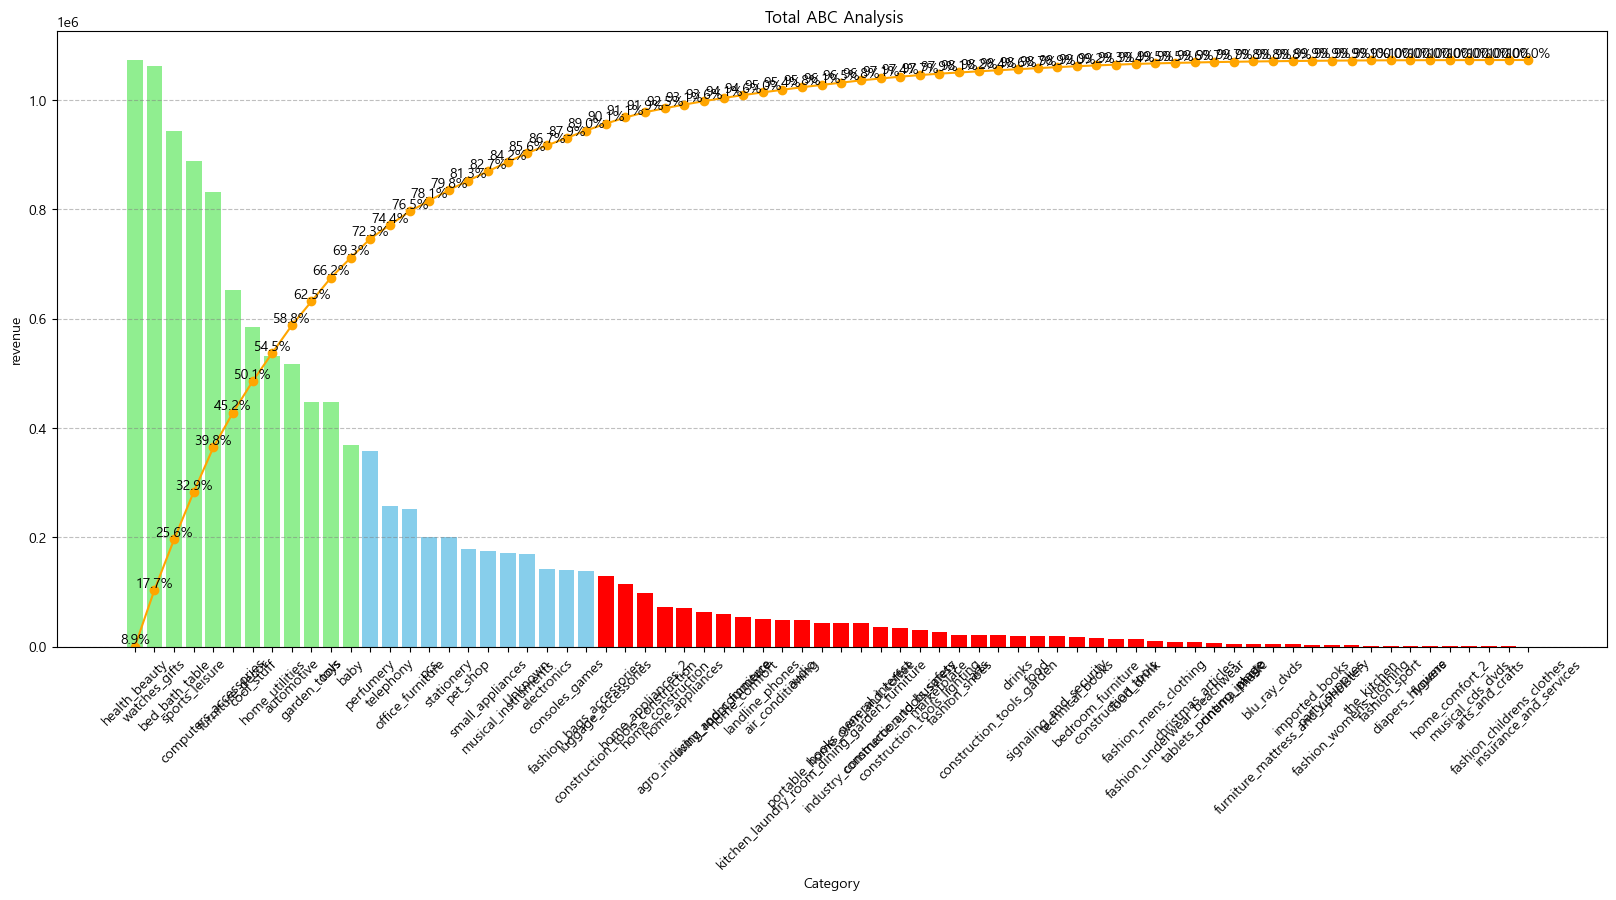

A 그룹 품목
 ['health_beauty', 'watches_gifts', 'bed_bath_table', 'sports_leisure', 'computers_accessories', 'furniture_decor', 'cool_stuff', 'home_utilities', 'automotive', 'garden_tools', 'toys', 'baby']
B 그룹 품목
 ['perfumery', 'telephony', 'office_furniture', 'pcs', 'stationery', 'pet_shop', 'small_appliances', 'musical_instruments', 'Unknown', 'electronics', 'consoles_games', 'fashion_bags_accessories']


In [186]:
# 전체 카테고리 중요도 A,B 그룹 품목 선정
A,B = total(cat)

## -처음 매출과 마지막 매출, 최근 3개월 A,B 매출 품목 비율 증감률 구하기

In [187]:
# 처음 매출과 마지막 매출 비율 증감률 확인 
# 최근 3개월 A,B 매출 품목 비율 증감률 확인

data=pd.read_csv('cat_ratio.csv')

# 전체 카테고리 중요도 A,B 리스트 품목 가져오기
s_data_A = data[A]
s_data_B = data[B]

growth_rates_A={}
recent1_rates_A={}
recent2_rates_A={}

# 증감률 계산
for column in s_data_A.columns:
    first_row_value = s_data_A[column].iloc[0]
    last_row_value = s_data_A[column].iloc[-1]    
    two_row_value = s_data_A[column].iloc[-2]
    three_row_value = s_data_A[column].iloc[-3]
    
    # 전체 증감률
    growth_rate = (last_row_value - first_row_value) / first_row_value * 100
    # 최근 1개월간 품목 매출 비율 증감률
    recent1_rate = (last_row_value - two_row_value) / two_row_value * 100
    # 한 달전 1개월간 품목 매출 비율 증감률
    recent2_rate = (two_row_value - three_row_value) / three_row_value * 100
    
    growth_rates_A[column] = growth_rate
    recent1_rates_A[column] = recent1_rate
    recent2_rates_A[column] = recent2_rate
    
# B
growth_rates_B={}
recent1_rates_B={}
recent2_rates_B={}

for column in s_data_B.columns:
    first_row_value = s_data_B[column].iloc[0]
    last_row_value = s_data_B[column].iloc[-1]
    two_row_value = s_data_B[column].iloc[-2]
    three_row_value = s_data_B[column].iloc[-3]
    
    growth_rate = (last_row_value - first_row_value) / first_row_value * 100
    recent1_rate = (last_row_value - two_row_value) / two_row_value * 100
    recent2_rate = (two_row_value - three_row_value) / three_row_value * 100
    
    growth_rates_B[column] = growth_rate
    recent1_rates_B[column] = recent1_rate
    recent2_rates_B[column] = recent2_rate

# 데이터 프레임화
growth_rates_A= pd.DataFrame(list(growth_rates_A.items()), columns=['Category', 'Total Growth_rate(%)'])
growth_rates_B = pd.DataFrame(list(growth_rates_B.items()), columns=['Category', 'Total Growth_rate(%)'])
recent1_rates_A = pd.DataFrame(list(recent1_rates_A.items()), columns=['Category', 'Recent1 Growth_rate(%)'])
recent2_rates_A = pd.DataFrame(list(recent2_rates_A.items()), columns=['Category', 'Recent2 Growth_rate(%)'])
recent1_rates_B = pd.DataFrame(list(recent1_rates_B.items()), columns=['Category', 'Recent1 Growth_rate(%)'])
recent2_rates_B = pd.DataFrame(list(recent2_rates_B.items()), columns=['Category', 'Recent2 Growth_rate(%)'])

## -분기별 예외 품목 구하기

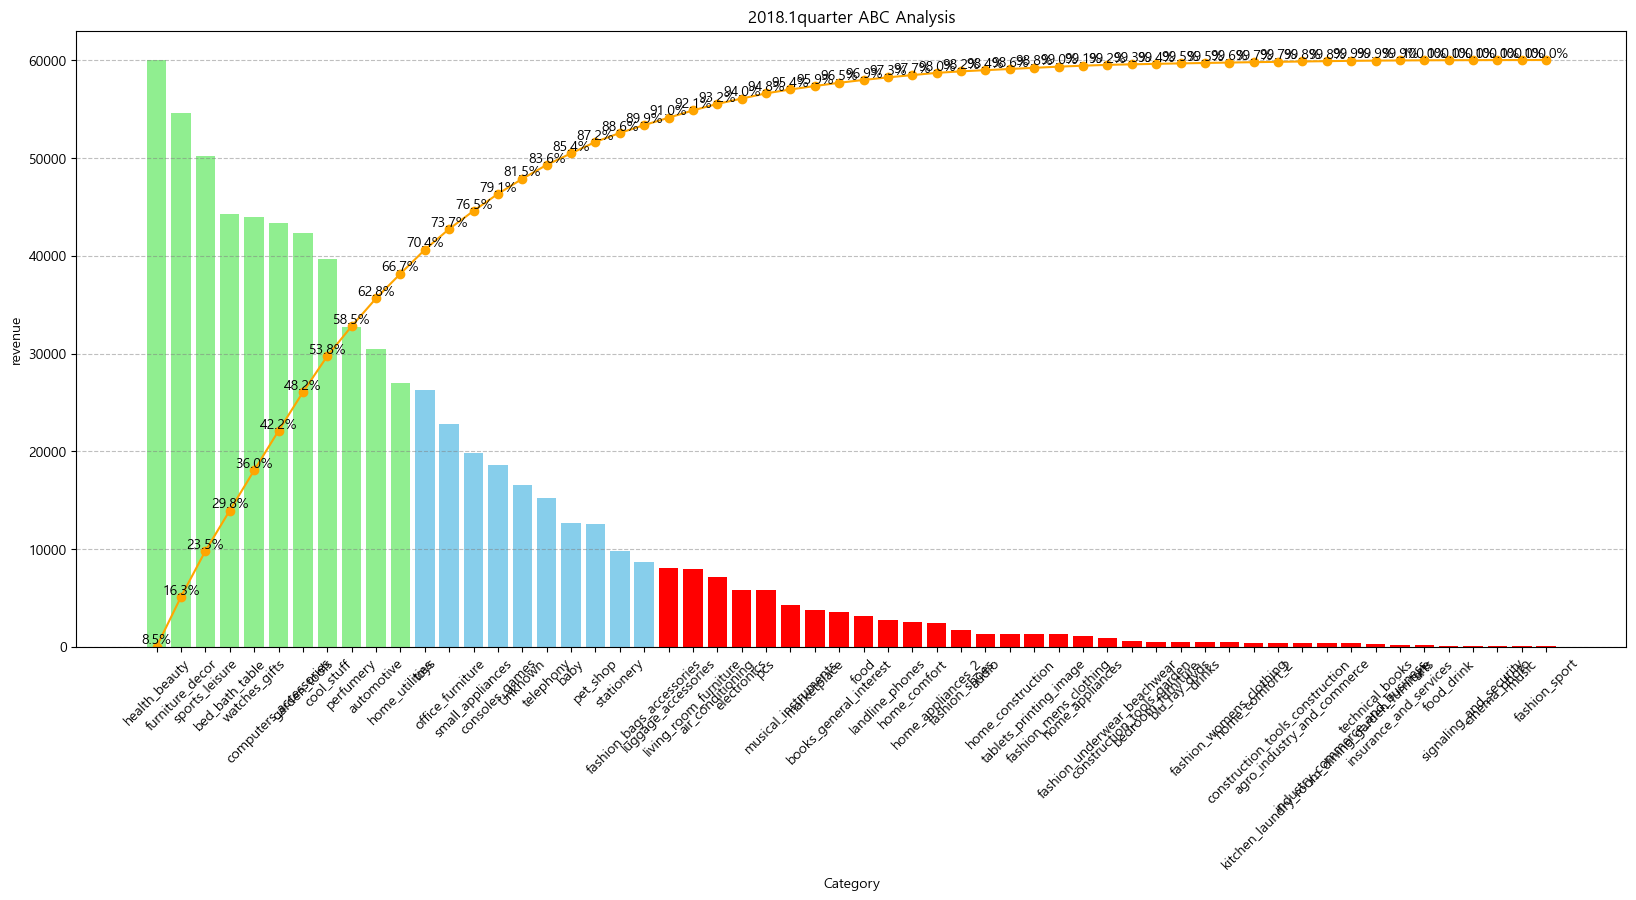

A 그룹 품목
 ['health_beauty', 'furniture_decor', 'sports_leisure', 'bed_bath_table', 'watches_gifts', 'computers_accessories', 'garden_tools', 'cool_stuff', 'perfumery', 'automotive', 'home_utilities']
B 그룹 품목
 ['toys', 'office_furniture', 'small_appliances', 'consoles_games', 'Unknown', 'telephony', 'baby', 'pet_shop', 'stationery', 'fashion_bags_accessories']


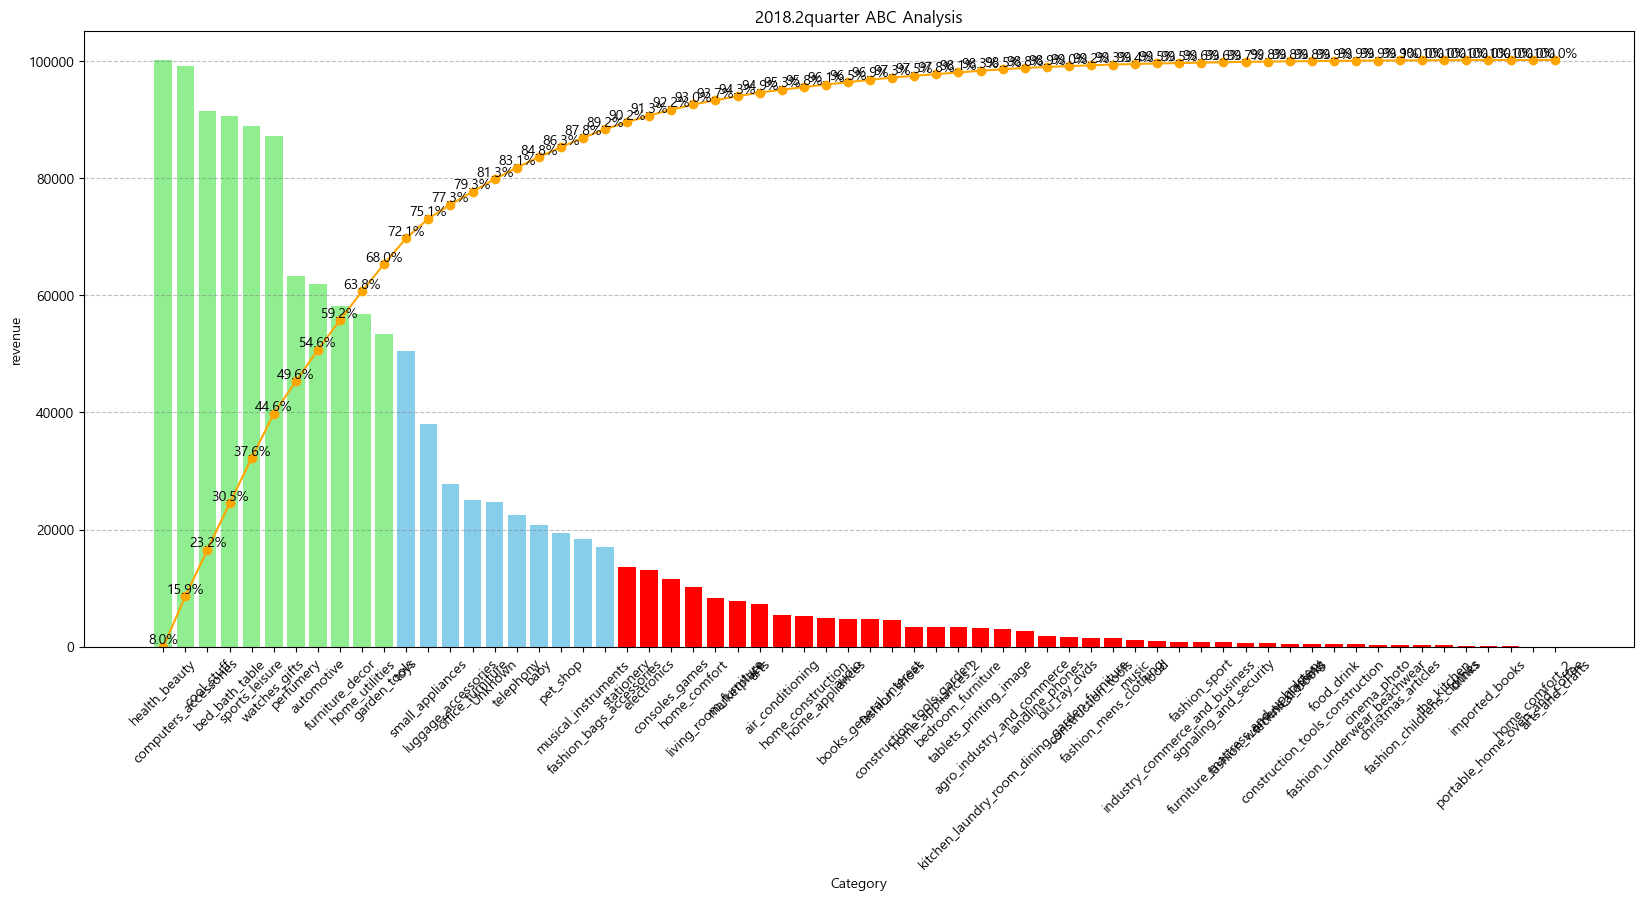

A 그룹 품목
 ['health_beauty', 'computers_accessories', 'cool_stuff', 'bed_bath_table', 'sports_leisure', 'watches_gifts', 'perfumery', 'automotive', 'furniture_decor', 'home_utilities', 'garden_tools']
B 그룹 품목
 ['toys', 'small_appliances', 'luggage_accessories', 'office_furniture', 'Unknown', 'telephony', 'baby', 'pet_shop', 'musical_instruments', 'fashion_bags_accessories']


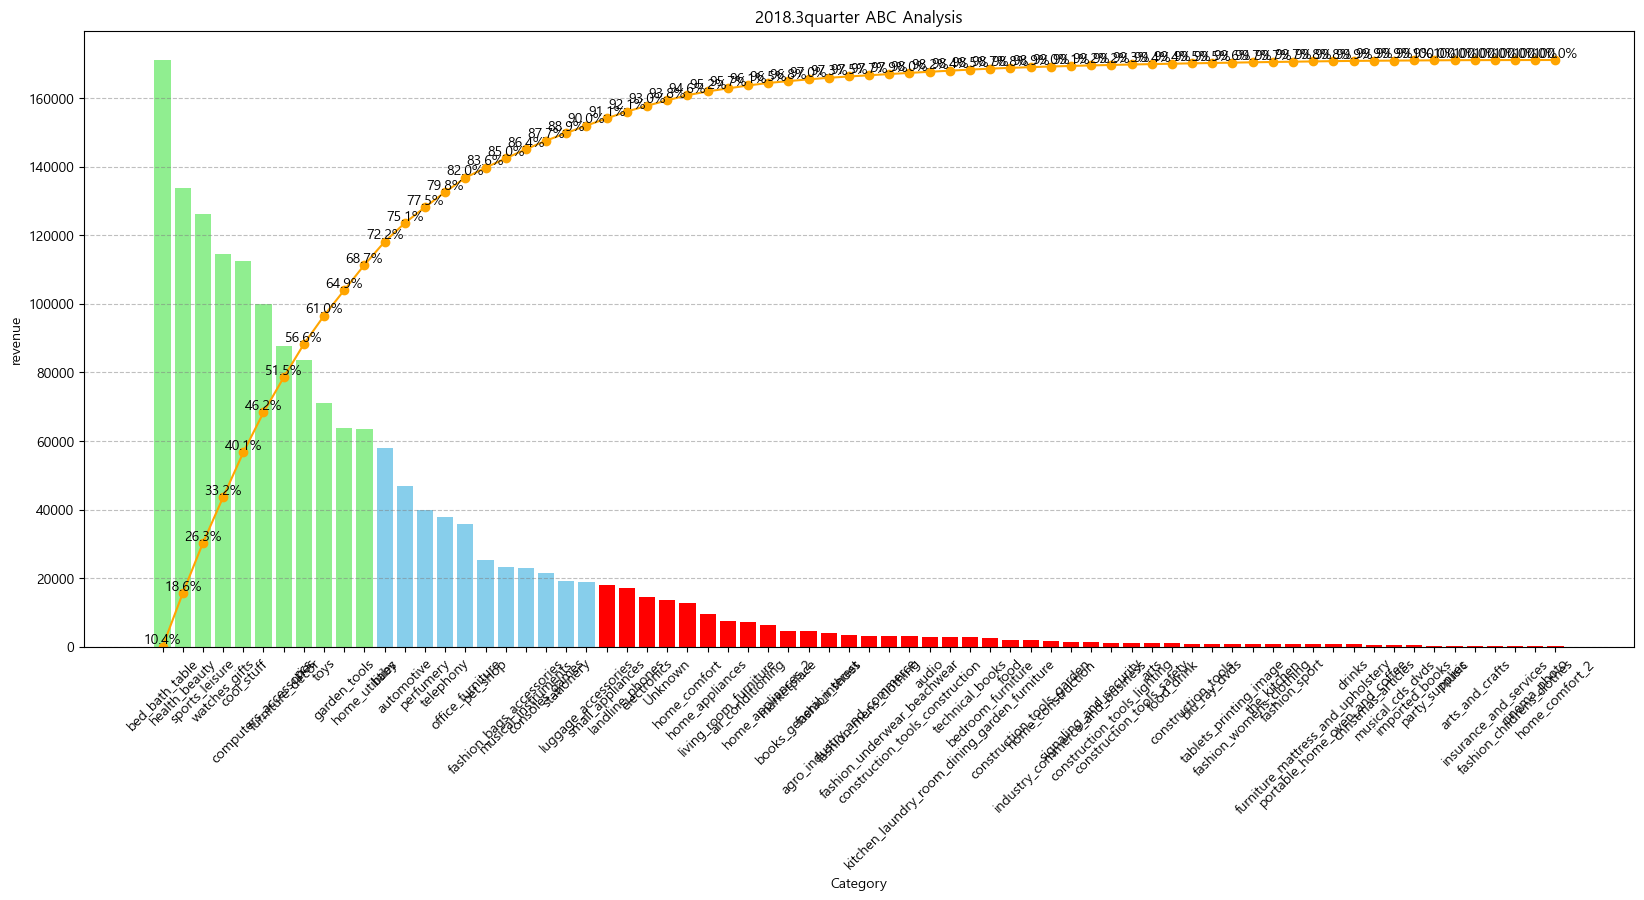

A 그룹 품목
 ['bed_bath_table', 'health_beauty', 'sports_leisure', 'watches_gifts', 'cool_stuff', 'computers_accessories', 'furniture_decor', 'pcs', 'toys', 'garden_tools', 'home_utilities']
B 그룹 품목
 ['baby', 'automotive', 'perfumery', 'telephony', 'office_furniture', 'pet_shop', 'fashion_bags_accessories', 'musical_instruments', 'consoles_games', 'stationery', 'luggage_accessories']


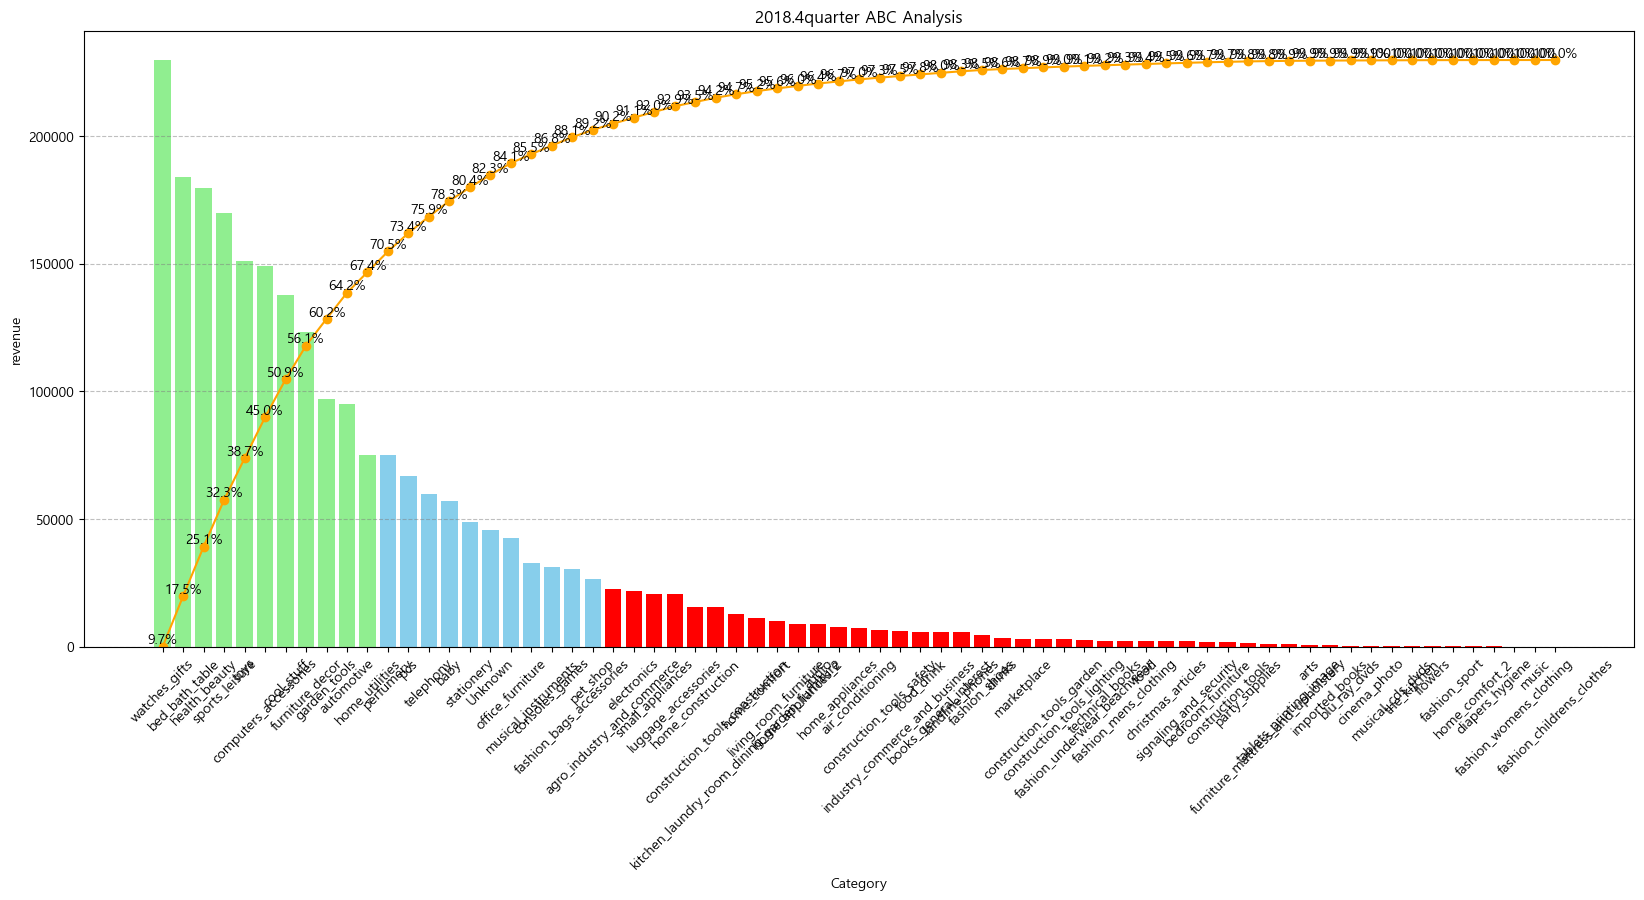

A 그룹 품목
 ['watches_gifts', 'bed_bath_table', 'health_beauty', 'sports_leisure', 'toys', 'computers_accessories', 'cool_stuff', 'furniture_decor', 'garden_tools', 'automotive', 'home_utilities']
B 그룹 품목
 ['perfumery', 'pcs', 'telephony', 'baby', 'stationery', 'Unknown', 'office_furniture', 'musical_instruments', 'consoles_games', 'fashion_bags_accessories', 'pet_shop']


In [188]:
# 분기별 예외 품목 선정
A_1,B_1 = quarter(cat,2018,1)
A_2,B_2 = quarter(cat,2018,2)
A_3,B_3 = quarter(cat,2018,3)
A_4,B_4 = quarter(cat,2018,4)

# 분기별 A,B 그룹에서 달라지는 품목 확인
un_data_A_1_2 = [cat for cat in A_1 + A_2 if cat not in A_1 or cat not in A_2]
un_data_A_2_3 = [cat for cat in A_2 + A_3 if cat not in A_2 or cat not in A_3]
un_data_A_3_4 = [cat for cat in A_3 + A_4 if cat not in A_3 or cat not in A_4]

un_data_B_1_2 = [cat for cat in B_1 + B_2 if cat not in B_1 or cat not in B_2]
un_data_B_2_3 = [cat for cat in B_2 + B_3 if cat not in B_2 or cat not in B_3]
un_data_B_3_4 = [cat for cat in B_3 + B_4 if cat not in B_3 or cat not in B_4]

# 중복을 제거한 분기별 예외 품목 리스트
un_data_A = list(set(un_data_A_1_2 + un_data_A_2_3 + un_data_A_3_4))
un_data_B = list(set(un_data_B_1_2 + un_data_B_2_3 + un_data_B_3_4))

In [189]:
# 분기별 달라진 품목 확인
un_data_A,un_data_B

(['toys', 'perfumery', 'automotive', 'pcs'],
 ['small_appliances',
  'automotive',
  'perfumery',
  'toys',
  'luggage_accessories',
  'Unknown',
  'pcs',
  'musical_instruments',
  'stationery',
  'consoles_games'])

## -분기별 예외 품목 판매 비율 시각화 함수

In [190]:
# 분기별 달라진 품목 매출 비율 시각화 
def visual(data,category):
    
    # 분기별 매출 비율 
    column_sum=[]
    vs = data[['index',category]]
    # 2018년 1분기 매출비율 더하기
    column_sum.append(sum(vs[category].iloc[0:3]))
    # 2018년 2분기 매출비율 더하기
    column_sum.append(sum(vs[category].iloc[3:6]))
    # 2018년 3분기 매출비율 더하기
    column_sum.append(sum(vs[category].iloc[6:9]))
    # 2018년 4분기 매출비율 더하기
    column_sum.append(sum(vs[category].iloc[9:12]))
    # 2019년 1분기 매출비율 더하기
    column_sum.append(sum(vs[category].iloc[12:15]))
    # 2019년 2분기 매출비율 더하기
    column_sum.append(sum(vs[category].iloc[15:18]))

    # X축 인덱스
    idx=['2018.1','2018.2','2018.3','2018.4','2019.1','2019.2']
    
    plt.figure(figsize=(4,4))
    plt.bar(idx, column_sum)
    plt.title(category)
    plt.show()
    return column_sum , idx

## -분기별 예외 품목 판매 비율 시각화 및 패턴 찾기

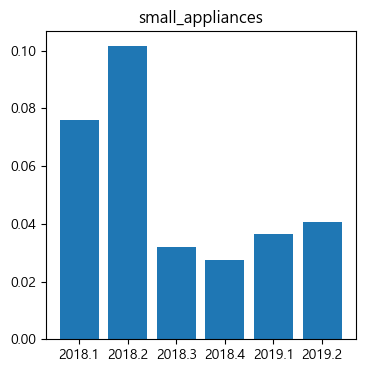

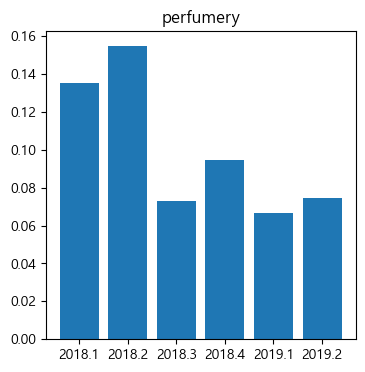

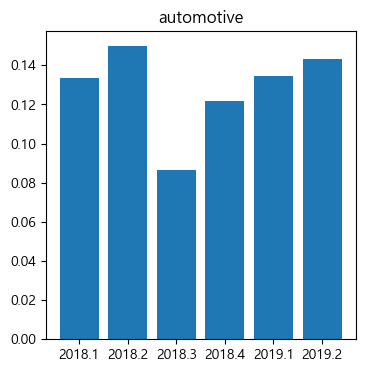

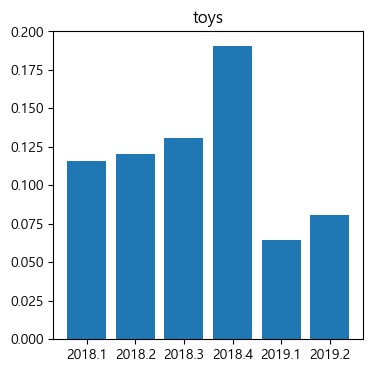

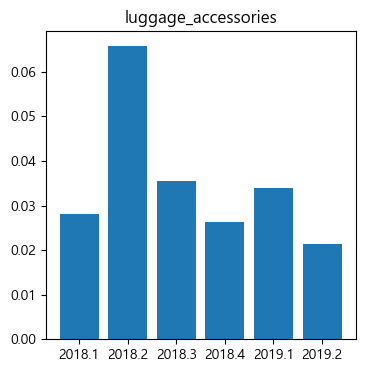

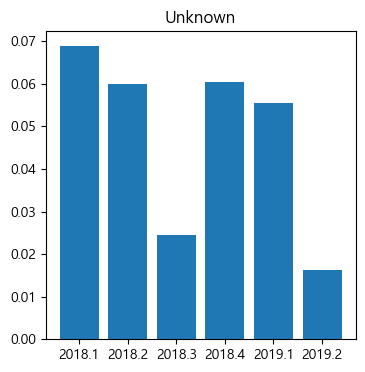

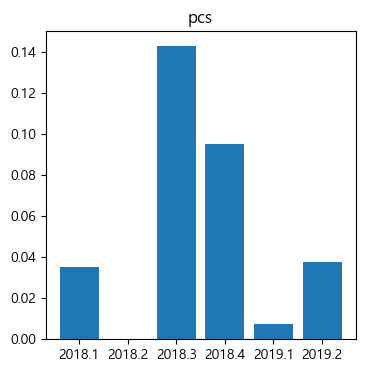

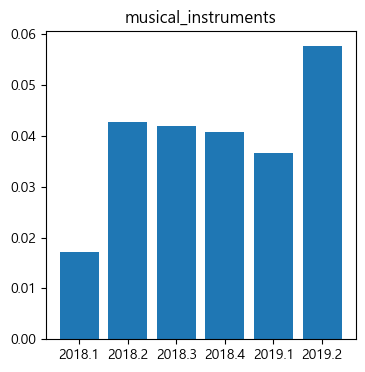

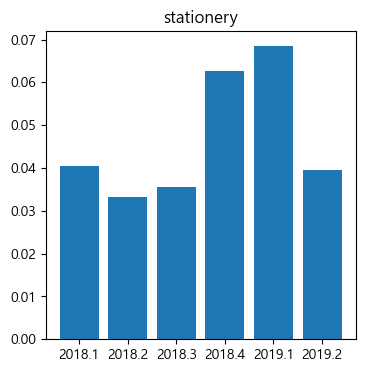

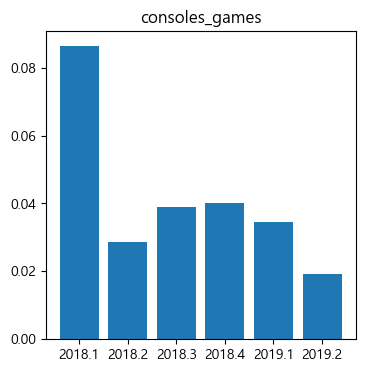

In [191]:
#매출 비율 csv 파일
data 

# 예외 품목 후보 리스트
ex_s = list(set(un_data_A + un_data_B))
num_plots = len(ex_s)

# 시각화
for i in range(num_plots): 
    visual(data,ex_s[i])

# 분기별 달라진 품목 확인
# 19년 3,4분기는 데이터가 없지만 그래프 추세로 예측

# toy 하반기로 갈수록 판매비율 증가 패턴 예측
# pcs 상반기 판매율 매우 저조 , 하반기 판매율 급증 패턴 예측

In [192]:
# 위 데이터 합치기
finish_A=pd.merge(growth_rates_A,recent1_rates_A, on = 'Category' , how='inner')
finish_A=pd.merge(finish_A,recent2_rates_A, on = 'Category' , how='inner')

finish_B=pd.merge(growth_rates_B,recent1_rates_B, on = 'Category' , how='inner')
finish_B=pd.merge(finish_B,recent2_rates_B, on = 'Category' , how='inner')

## -A,B 품목 리스트

In [193]:
finish_A

,Category,Total Growth_rate(%),Recent1 Growth_rate(%),Recent2 Growth_rate(%)
0,health_beauty,5.229937,-6.415397,28.689370
1,watches_gifts,55.172414,12.500000,-18.233851
2,bed_bath_table,97.041420,-20.239521,14.855571
3,sports_leisure,-13.990268,34.155598,-13.179572
4,computers_accessories,32.386364,-4.703476,-5.780347
5,furniture_decor,-54.735013,6.326531,-10.420475
6,cool_stuff,-65.040650,-2.272727,-28.338762
7,home_utilities,173.622047,7.253086,0.465116
8,automotive,18.287037,-1.919386,24.641148
9,garden_tools,-46.119403,73.557692,-45.974026


In [194]:
finish_B

,Category,Total Growth_rate(%),Recent1 Growth_rate(%),Recent2 Growth_rate(%)
0,perfumery,-46.506550,-21.974522,25.099602
1,telephony,173.529412,-30.597015,38.144330
2,office_furniture,-44.230769,-59.722222,-32.710280
3,pcs,-76.649746,-68.493151,64.044944
4,stationery,22.142857,12.500000,18.750000
5,pet_shop,187.500000,-8.407080,88.333333
6,small_appliances,-16.107383,-27.325581,57.798165
7,musical_instruments,283.333333,-40.104167,3.225806
8,Unknown,-59.027778,110.714286,-46.153846
9,electronics,110.909091,1.754386,-31.325301


In [195]:
# A,B 품목 리스트 정규화 함수
scaler = MinMaxScaler()

# A
num_cols = finish_A.select_dtypes(include=['number']).columns

# 숫자형 열만 정규화
finish_A_n = finish_A.copy() 
finish_A_n[num_cols] = scaler.fit_transform(finish_A_n[num_cols])

# B
num_cols = finish_B.select_dtypes(include=['number']).columns

finish_B_n = finish_B.copy() 
finish_B_n[num_cols] = scaler.fit_transform(finish_B_n[num_cols])

## -RCI값 추가

In [196]:
# RCI 컬럼 추가 
# 전체 품목 매출 비율 증감률 가중치 = 0.4 
# 최근 1개월전 품목 매출 비율 증감률 가중치 = 0.4
# 최근 2개월전 품목 매출 비율 증감률 가중치 = 0.2
# RCI = 전체 품목 매출 비율 증감률 *(0.4) + 최근 1개월간 품목 매출 비율 증감률*(0.4) + 한 달전 1개월간 품목 매출 비율 증감률 *(0.2)

finish_A_n['RCI']=finish_A_n['Total Growth_rate(%)']*0.4 + finish_A_n['Recent1 Growth_rate(%)']*0.4 + finish_A_n['Recent2 Growth_rate(%)']*0.2
finish_A_n=finish_A_n.sort_values(by='RCI', ascending=False)
finish_A_n

,Category,Total Growth_rate(%),Recent1 Growth_rate(%),Recent2 Growth_rate(%),RCI
7,home_utilities,1.000000,0.413511,0.621980,0.689800
2,bed_bath_table,0.679126,0.170329,0.814718,0.502726
8,automotive,0.349144,0.332377,0.945780,0.461765
1,watches_gifts,0.503694,0.459922,0.371536,0.459754
0,health_beauty,0.294435,0.292608,1.000000,0.434817
3,sports_leisure,0.213902,0.651474,0.439231,0.433996
9,garden_tools,0.079280,1.000000,0.000000,0.431712
4,computers_accessories,0.408221,0.307751,0.538332,0.394055
5,furniture_decor,0.043181,0.405315,0.476184,0.274635
6,cool_stuff,0.000000,0.329252,0.236197,0.178940


In [197]:
finish_B_n['RCI']=finish_B_n['Total Growth_rate(%)']*0.4 + finish_B_n['Recent1 Growth_rate(%)']*0.4 + finish_B_n['Recent2 Growth_rate(%)']*0.2
finish_B_n=finish_B_n.sort_values(by='RCI', ascending=False)
finish_B_n

,Category,Total Growth_rate(%),Recent1 Growth_rate(%),Recent2 Growth_rate(%),RCI
5,pet_shop,0.734615,0.335288,1.000000,0.627961
7,musical_instruments,1.000000,0.158414,0.367170,0.536800
1,telephony,0.695928,0.211465,0.626812,0.488320
8,Unknown,0.051923,1.000000,0.000000,0.420769
4,stationery,0.276703,0.451952,0.482602,0.387983
9,electronics,0.522517,0.391990,0.110260,0.387855
10,consoles_games,0.000000,0.444202,0.736011,0.324883
6,small_appliances,0.170780,0.229720,0.772951,0.314790
0,perfumery,0.086597,0.259580,0.529816,0.244434
3,pcs,0.003124,0.000000,0.819400,0.165130


## -최종 집중 품목 선정

In [198]:
# RCI 0.5 이상 + 예외(분기별 추천)

# A 그룹 품목 집중 품목
print_A = finish_A_n[finish_A_n['RCI']>=0.5][['Category','RCI']]
print_A

,Category,RCI
7,home_utilities,0.689800
2,bed_bath_table,0.502726


In [199]:
# B 그룹 품목 집중 품목
print_B = finish_B_n[finish_B_n['RCI']>=0.5][['Category','RCI']]
print_B

,Category,RCI
5,pet_shop,0.627961
7,musical_instruments,0.536800


# [비지니스 제안]

## -분석 결과
* A 그룹 - home_utilities, bed_bath_table  
매출 유지 및 증진을 위한 마케팅 전략 및 재고관리를 통한 비용절감   
 
* B 그룹 - pet_shop, musical_instruments  
성장 가능성 높은 품목의 마케팅 전략 및 재고관리를 통한 비용절감  

 +예외 추천 품목 - toys , pcs 

※19년 3,4분기는 데이터가 없지만 그래프 추세로 예측※
 - toy 하반기로 갈수록 판매비율 증가 패턴 예측 
 - pcs 상반기 판매율 매우 저조 , 하반기 판매율 급증 패턴 예측 

## -제안서
해당 ABC 커스텀 분석 결과 A그룹 품목은 가정용품과 침실,화장실 용품이 나왔다. 해당 품목들의 특징은 일상생활에서 사용되는 제품들이다. 매출의 70%를 담당하는 A그룹에서도 뛰어난 성장율을 가지고 있어 효율적인 재고관리와 매출 유지 및 증진을 위해 다음과 같은 마케팅 전략을 제안한다.  

* 이벤트, 세일  
* 제품 다양화 및 신제품 판매
* 성장율에 따른 적절한 재고 수 관리
* 묶음 패키지 판매(가정용품 + 침실 + 화장실 용품) 
* 소셜 미디어 및 블로그 리뷰 이벤트 > 소셜 미디어 플랫폼 및 블로그를 활용하여 제품을 리뷰하고 보상을 제공

B그룹 품목에서는 애완용품과 악기, 전화기가 나왔다. 매출의 20%를 담당하는 B그룹에서 성장 가능성이 높은 제품들이다. 해당 품목들이 A그룹으로 올라가기 위한 마케팅 전략을 제안한다.  

* 이벤트, 세일
* 제품 다양화 및 신제품 판매
* 성장율에 따른 적절한 재고 수 관리
* 타겟팅 광고 이벤트 > 애완용품과 악기 제품 특성상 해당 타겟 고객층을 파악하여 맞춤형 광고  

예외 품목로는 A그룹에 속하는 장난감은 하반기로 갈수록 판매비율이 증가하는 패턴이 예측된다. 따라서 하반기 크리스마스 및 연말 선물 시즌을 고려하여 재고 수를 늘리고 특별 이벤트 및 세일을 진행한다. 다른 예외품목으로는 B그룹에 개인 컴퓨터이다. 개인 컴퓨터는 상반기에는 판매율이 매우 저조하지만 하반기에는 판매율이 급증하는 패턴이 예측된다. 상반기 판매율 저조 예측에 따라, 하반기에는 업그레이드 및 교체 시즌을 고려하여 재고 수를 조절하고 개인 컴퓨터 관련 이벤트를 개학 시기나 업무 관련 이벤트와 연계하여 집중적으로 진행한다.

이렇듯 RCI 분석 결과에 따라서 테고리의 우선순위를 측정해 각각 비지니스에 맞는 집중 마케팅 전략을 실행함으로써 기회비용을 최소화하고 매출을 증대시킬 수 있다. 또 주력 카테고리의 재고관리 강화를 통해 재고 비용을 절감하고 고객 서비스 수준을 향상시킬 수 있다. 